In [1]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Step 1: Load the dataset
data = pd.read_csv('understat_per_game.csv')

In [1]:
# Step 2: Handle outliers in the target variable ('scored') using the IQR method
Q1 = data['scored'].quantile(0.25)
Q3 = data['scored'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data = data[(data['scored'] >= lower_bound) & (data['scored'] <= upper_bound)]
print(f"Dataset shape after removing outliers: {data.shape}")

In [1]:
# Step 3: Create target classes for binary classification (under 2.5 goals = 0, over 2.5 goals = 1)
def classify_binary_goals(goals):
    return 1 if goals > 2.5 else 0

data['scored_binary'] = data['scored'].apply(classify_binary_goals)

Dataset shape after removing outliers: (24420, 29)
Accuracy: 0.8409

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4113
           1       0.48      0.10      0.16       771

    accuracy                           0.84      4884
   macro avg       0.67      0.54      0.54      4884
weighted avg       0.79      0.84      0.79      4884



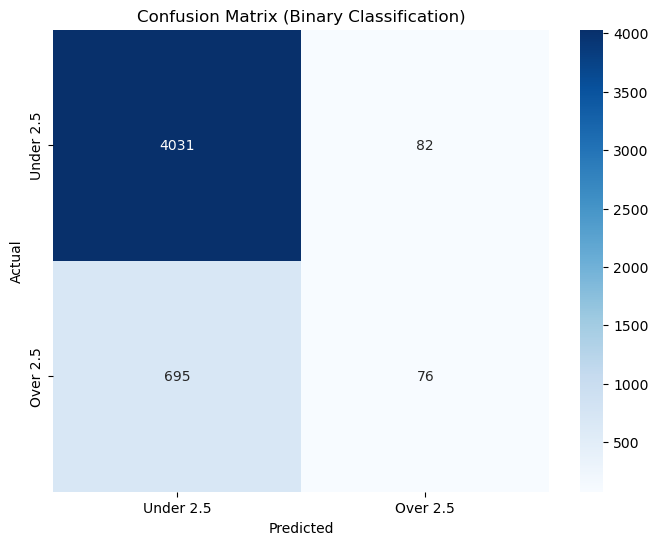


Cross-Validation Accuracy:
Mean: 0.8450, Std: 0.0021
Scores: [0.84493347 0.84873304 0.84335808 0.84259022 0.84514973]

Top 20 Feature Importance based on XGBoost:
                     Feature  Importance
1                       deep    0.094302
8                  oppda_att    0.056264
20               league_RFPL    0.053917
10           ppda_efficiency    0.047617
5                   ppda_att    0.046383
3                     missed    0.046356
16                     h_a_h    0.045895
11          oppda_efficiency    0.044626
15            intensity_diff    0.043265
4                  ppda_coef    0.043201
13            ppda_intensity    0.043150
12  relative_ppda_efficiency    0.042870
18            league_La_liga    0.042332
14           oppda_intensity    0.041389
7                 oppda_coef    0.039785
17                league_EPL    0.039287
21            league_Serie_A    0.039086
9                  oppda_def    0.039067
2               deep_allowed    0.039050
19            le

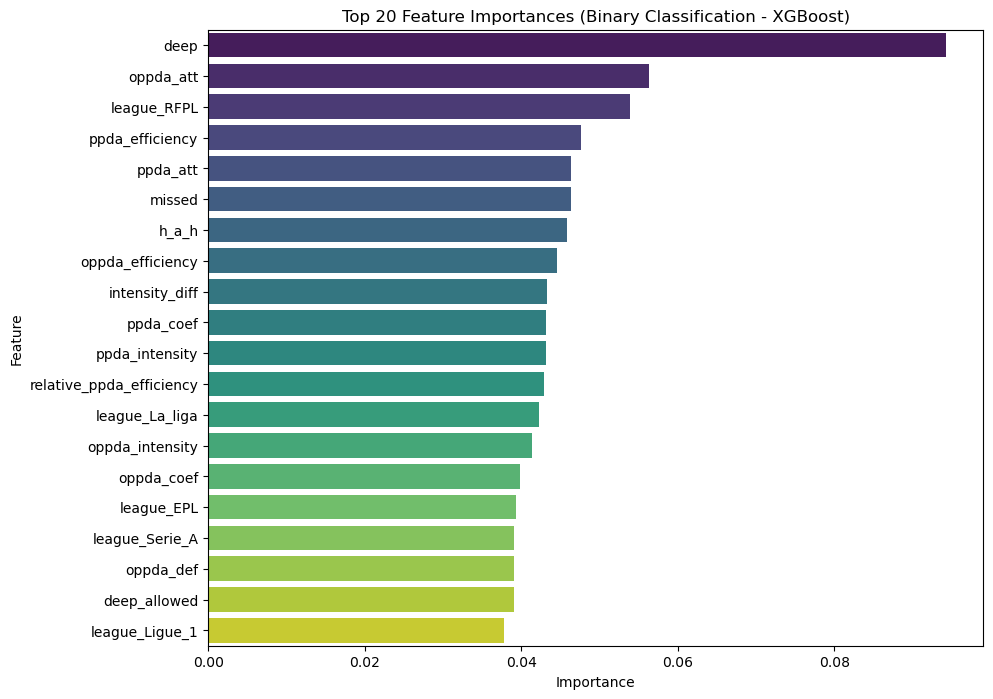

In [1]:
# Step 4: Drop high-correlation features and non-useful columns
high_corr_features = ['pts', 'npxG', 'npxGD', 'xG', 'xG_diff', 'wins', 'npxG', 
                      'xpts', 'xGA_diff', 'xGA', 'npxGA', 'xpts_diff', 'loses', 'draws']
data = data.drop(columns=high_corr_features + ['result', 'date', 'team', 'scored'])

# Step 5: Feature Engineering
data['ppda_efficiency'] = data['ppda_att'] / (data['ppda_def'] + 1)
data['oppda_efficiency'] = data['oppda_att'] / (data['oppda_def'] + 1)
data['relative_ppda_efficiency'] = data['ppda_efficiency'] / (data['oppda_efficiency'] + 1)
data['ppda_intensity'] = data['ppda_coef'] * data['ppda_att']
data['oppda_intensity'] = data['oppda_coef'] * data['oppda_att']
data['intensity_diff'] = data['ppda_intensity'] - data['oppda_intensity']

# Apply one-hot encoding to categorical columns ('h_a', 'league')
data = pd.get_dummies(data, columns=['h_a', 'league'], drop_first=True)

# Step 6: Define target and features for binary classification
X = data.drop(columns=['scored_binary'])  # Features
y = data['scored_binary']  # Target variable (binary classes)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Initialize XGBoost Classifier for binary classification
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    objective='binary:logistic',  # Objective for binary classification
    random_state=42
)

# Step 9: Train the model
xgb_model.fit(X_train, y_train)

# Step 10: Make predictions
y_pred = xgb_model.predict(X_test)

# Step 11: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Binary Classification)')
plt.show()

# Step 12: Cross-Validation Accuracy
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:")
print(f"Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
print(f"Scores: {cv_scores}")

# Step 13: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Feature Importance based on XGBoost:")
print(feature_importance.head(20))

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances (Binary Classification - XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Top 10 Feature Importance based on XGBoost:
             Feature  Importance
1               deep    0.094302
8          oppda_att    0.056264
20       league_RFPL    0.053917
10   ppda_efficiency    0.047617
5           ppda_att    0.046383
3             missed    0.046356
16             h_a_h    0.045895
11  oppda_efficiency    0.044626
15    intensity_diff    0.043265
4          ppda_coef    0.043201


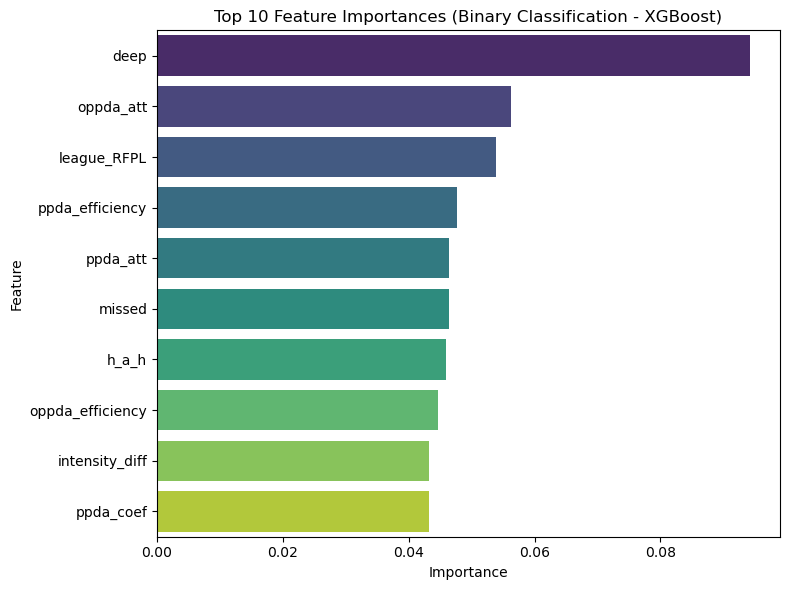

100%|===================| 4865/4884 [01:28<00:00]        

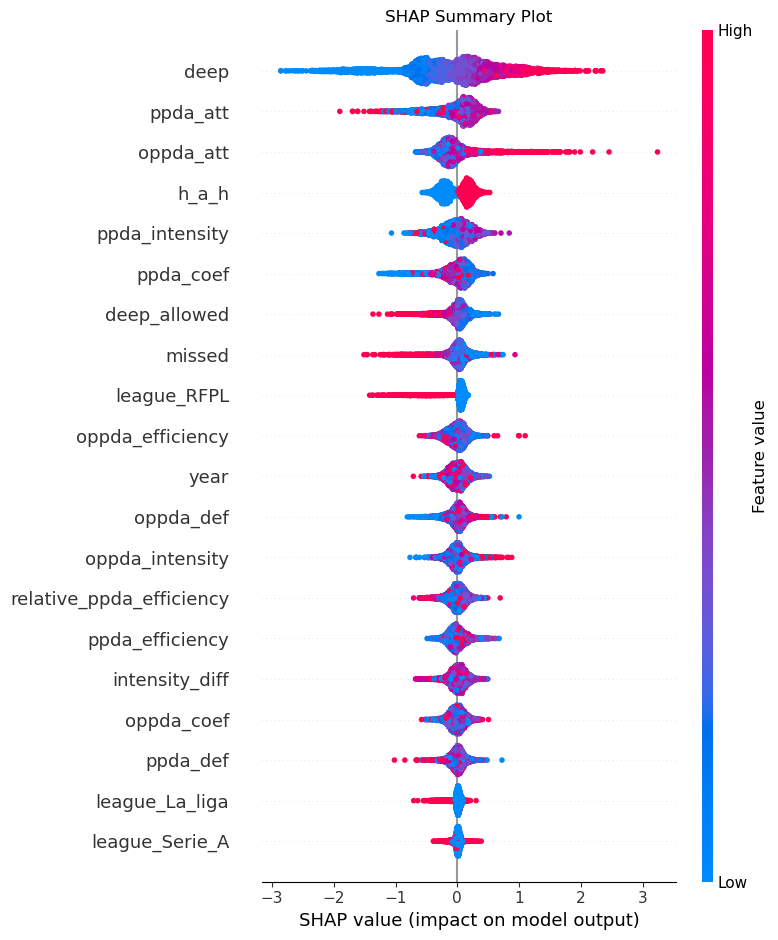

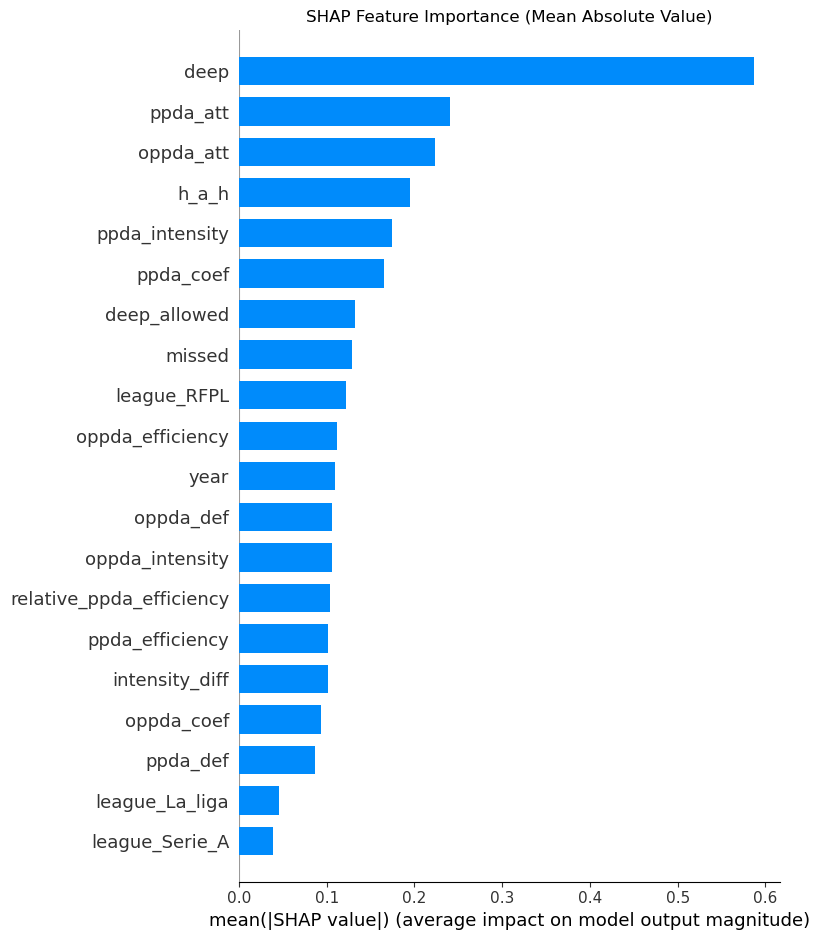

In [6]:
# Import SHAP for feature explanation
import shap

# Display Top 10 Feature Importances
top_10_features = feature_importance.head(10)
print("\nTop 10 Feature Importance based on XGBoost:")
print(top_10_features)

# Plot Top 10 Feature Importances
plt.figure(figsize=(8, 6))
sns.barplot(data=top_10_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Feature Importances (Binary Classification - XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Step 14: SHAP Analysis
explainer = shap.Explainer(xgb_model, X_train)  # Create SHAP explainer
shap_values = explainer(X_test)  # Calculate SHAP values for test set

# SHAP Summary Plot
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test)

# SHAP Feature Importance (Bar Plot)
plt.title("SHAP Feature Importance (Mean Absolute Value)")
shap.summary_plot(shap_values, X_test, plot_type="bar")
